https://www.kaggle.com/code/arezoodahesh/customer-churn-with-oversampling-techniques#Import-Libraries

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, RandomOverSampler

from scipy import stats
import joblib

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [4]:
from funcs.plots.confusion_matrix import plot_confusion_matrix
from funcs.plots.roc_curves import plot_roc_curves, plot_roc_area_curve
from funcs.plots.tpr_fpr_thresholds import plot_tpr_fpr_thresholds
from funcs.plots.distribution import plot_violin_binary_dist, plots_kde

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
df = pd.read_csv("F:/Data/datas/WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col=0)
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

In [7]:
NUM_COLS = ["tenure", "MonthlyCharges", "TotalCharges"]

## Data Preparation

### Data Cleaning

#### Drop 0 Tenure

In [8]:
df = df.drop(index=df[df['tenure'] == 0].index)

#### Drop Missing Values

In [9]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("Missing Values:", df['TotalCharges'].isna().sum())
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
print("Missing Values:", df['TotalCharges'].isna().sum())

Missing Values: 0
Missing Values: 0


#### Handling Outliers (Optional)

In [10]:
def replace_outliers(df, columns):
    df = df.copy()
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3-Q1
        
        top_cap = Q3 + (IQR * 1.5)
        bottom_cap = Q1 - (IQR * 1.5)
        
        if df[col].max() > top_cap:
            print("above bottom cap:", df[df[col] > top_cap].shape[0])            
            df[col] = df[col].apply(lambda x: top_cap if x > top_cap else x)
        if df[col].min() < bottom_cap:
            print("below bottom cap:", df[df[col] < top_cap].shape[0])
            df[col] = df[col].apply(lambda x: bottom_cap if x < bottom_cap else x)
                
    return df

In [11]:
def replace_outliers_by_group(df, columns, col_group):
    df = df.copy()
    groups = df[col_group].unique()
    
    for col in columns:
        df[col] = df[col].astype(float)
    
    for group in groups:
        datas = df[df[col_group] == group]
        for col in columns:
            data = datas[col]
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3-Q1

            top_cap = Q3 + (IQR * 1.5)
            bottom_cap = Q1 - (IQR * 1.5)

            if data.max() > top_cap:                
                idx_above_cap = data[data > top_cap].index
                print(f"above top cap ({col} | {group}):", len(idx_above_cap))
                df.loc[idx_above_cap, col] = top_cap
            if df[col].min() < bottom_cap:
                idx_below_cap = data[data < bottom_cap].index
                print(f"below bottom cap ({col}):", len(idx_below_cap))
                df.loc[idx_below_cap, col] = idx_below_cap
                
    return df

##### Without Grouping

In [ ]:
fig_kde_outliers = plots_kde(df, ['tenure', 'TotalCharges', 'MonthlyCharges'], 1)

No outliers were detected when we didn't group them by "Churn" label

In [ ]:
fig_kde_outliers

In [ ]:
df = replace_outliers(df, ['tenure', 'TotalCharges', 'MonthlyCharges'])

##### Grouping by Churn

Some outliers were detected if we group them by "Churn"

In [ ]:
plot_violin_binary_dist(df, 'tenure', 'Churn')

In [ ]:
plot_violin_binary_dist(df, 'TotalCharges', 'Churn')

In [ ]:
plot_violin_binary_dist(df, 'MonthlyCharges', 'Churn')

In [12]:
df = replace_outliers_by_group(df, ['tenure', 'TotalCharges', 'MonthlyCharges'], 'Churn')

above top cap (tenure | 1): 23
above top cap (TotalCharges | 1): 109


### Features Encoding

#### Nominal Data into Binary

We convert our nominal data into binary values.

In [13]:
for col in df.select_dtypes('object').columns:
    print(f"{col}: \n{df[col].unique()}\n")

gender: 
['Female' 'Male']

Partner: 
['Yes' 'No']

Dependents: 
['No' 'Yes']

PhoneService: 
['No' 'Yes']

MultipleLines: 
['No phone service' 'No' 'Yes']

InternetService: 
['DSL' 'Fiber optic' 'No']

OnlineSecurity: 
['No' 'Yes' 'No internet service']

OnlineBackup: 
['Yes' 'No' 'No internet service']

DeviceProtection: 
['No' 'Yes' 'No internet service']

TechSupport: 
['No' 'Yes' 'No internet service']

StreamingTV: 
['No' 'Yes' 'No internet service']

StreamingMovies: 
['No' 'Yes' 'No internet service']

Contract: 
['Month-to-month' 'One year' 'Two year']

PaperlessBilling: 
['Yes' 'No']

PaymentMethod: 
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']



In [14]:
df['gender'] = df['gender'].map({'Male':1, 'Female':0})
df['Partner'] = df['Partner'].map({'Yes':1, 'No':0})
df['Dependents'] = df['Dependents'].map({'Yes':1, 'No':0})
df['PhoneService'] = df['PhoneService'].map({'Yes':1, 'No':0})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes':1, 'No':0})

In [15]:
df.describe(include='object')

,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,3,3,3,3,3,3,3,3,3,4
top,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check
freq,3385,3096,3497,3087,3094,3472,2809,2781,3875,2365


#### Ordinal Data into Stratificiation encoding

We considered ordinal data has a stratification values

In [16]:
def target_encoder(df, y:"independent variable"):
    df = df.copy()
    mapping = {}
    
    if y in df.select_dtypes(exclude='number').columns:
        df[y] = LabelEncoder().fit_transform(df[y])
    
    for col in df.select_dtypes(exclude='number').columns:
        grouped = df[[y, col]].groupby(col).agg('mean')
        sort_idx = grouped.sort_values(y).index
        remap = {idx: rank for idx, rank in zip(sort_idx, range(len(sort_idx)))}
        mapping[col] = {v:k for k, v in remap.items()}
        df[col] = df[col].map(remap)
    
    return df, mapping

In [17]:
df, mapping = target_encoder(df, 'Churn')

### Data Preprocessing and Processing

#### Data Scaling (Change the range of values)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [ ]:
df[NUM_COLS].hist(figsize=(12, 2), bins=100, layout=(1, 3));

In [ ]:
ss = StandardScaler()
df.loc[:, NUM_COLS] = ss.fit_transform(df[NUM_COLS])

In [ ]:
df[NUM_COLS].hist(figsize=(12, 2), bins=100, layout=(1, 3));

#### Data Transformation (Change the shape of distribution)

In [18]:
from sklearn.preprocessing import PowerTransformer

In [19]:
print("skewness")
print('yeo-johnson: ', pd.DataFrame(PowerTransformer(method='yeo-johnson').fit_transform(df[NUM_COLS])).skew().abs().sum())
print('box-cox: ', pd.DataFrame(PowerTransformer(method='box-cox').fit_transform(df[NUM_COLS])).skew().abs().sum())
print('sqrt: ', np.sqrt(df[NUM_COLS]).skew().abs().sum())
print('cbrt: ', np.cbrt(df[NUM_COLS]).skew().abs().sum())
print('log: ', np.log(df[NUM_COLS]).skew().abs().sum())
print('log1p: ', np.log1p(df[NUM_COLS]).skew().abs().sum())

skewness
yeo-johnson:  0.6498133292516175
box-cox:  0.6988480893392347
sqrt:  1.0167197031782584
cbrt:  1.0196118879109115
log:  2.450998772169236
log1p:  2.2445118665109236


In [20]:
df[NUM_COLS] = PowerTransformer(method='yeo-johnson').fit_transform(df[NUM_COLS])

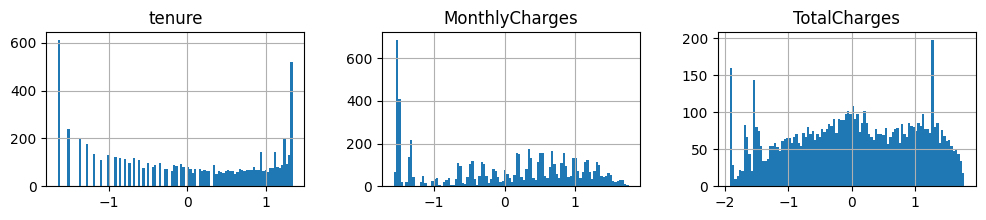

In [21]:
df[NUM_COLS].hist(figsize=(12, 2), bins=100, layout=(1, 3));

## Feature Selection

In [22]:
def vif(df, y:'y will droped', scale=True):
    df = df.drop(y, axis=1).copy()
    index = df.columns.tolist()
    
    if scale:
        df = pd.DataFrame(StandardScaler().fit_transform(df))

    vif = pd.Series([variance_inflation_factor(df.values, i) for i in range(df.shape[1])], index=index)
    
    return pd.DataFrame(vif, index=index, columns=['vif']).sort_values(by='vif', ascending=False)

In [24]:
vif(df[NUM_COLS + ['Churn']], 'Churn')

,vif
TotalCharges,47.235092
tenure,31.190673
MonthlyCharges,9.445823


In [25]:
vif(df, 'Churn')

,vif
TotalCharges,58.555252
tenure,42.031619
MonthlyCharges,28.297118
InternetService,14.646536
TechSupport,4.318437
OnlineSecurity,3.982891
StreamingMovies,3.865185
StreamingTV,3.858371
DeviceProtection,3.710979
OnlineBackup,3.299587


## Data Modeling

### Split Dataset

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

### Handling Imbalanced Data Label

#### SMOTE

Oversampling: Increase the number of samples in the minority class

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote_resampled, y_smote_resampled = smote.fit_resample(X, y)

In [ ]:
y_smote_resampled.value_counts()

### Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote_resampled, y_smote_resampled, test_size=0.3, random_state=42)

### Models Fitting

In [ ]:
def fitting_models(obj_model, X_train, y_train, X_test, y_test):
    obj_model.fit(X_train, y_train)
    y_pred = obj_model.predict(X_test)
    y_pred_prob = obj_model.predict_proba(X_test)
    
    print("train score:", obj_model.score(X_train, y_train))
    print("test score:", obj_model.score(X_test, y_test))
    
    return y_pred, y_pred_prob

In [ ]:
lg_model = LogisticRegression(max_iter=100).fit(X_train, y_train)
y_pred_lg = lg_model.predict(X_test)
y_score_lg = lg_model.predict_proba(X_test)[:,1]

In [ ]:
print("train score:", lg_model.score(X_train, y_train))
print("test score:", lg_model.score(X_test, y_test))

In [ ]:
clf_xgb_model = XGBClassifier()
clf_xgb_model.fit(X_train, y_train, verbose=True, eval_metric='aucpr', 
            early_stopping_rounds=10, eval_set=[(X_test, y_test)])

In [ ]:
print("train score:", clf_xgb_model.score(X_train, y_train))
print("test score:", clf_xgb_model.score(X_test, y_test))

## Model Optimization

## Model Evaluation

### Classification Report

In [ ]:
print(classification_report(y_pred_lg, y_test, output_dict=False))

The classification report indicates that our model:

- Overall Accuracy: Achieves an accuracy of 81% (f1-score).
- Performance on Non-Churn Customers:
    - Accuracy: 88% f1-score.
    - Precision: 90% (higher than recall), indicating that the model tends to assume customers are loyal.
    - Recall: 85%, which, along with the higher precision, suggests an imbalance in the dataset where non-churn cases are more prevalent.
- Performance on Churn Customers:
    - Accuracy: 62% f1-score, indicating weaker performance.
    - Precision: 57% (lower than recall), suggesting the model is cautious in predicting churn, leading to fewer false positives.
    - Recall: 62%, which shows the model identifies more actual churn cases but at the cost of lower precision.
- Overall, the model shows good performance in predicting non-churn customers but struggles with accurately identifying churn customers, highlighting areas for potential improvement

In [ ]:
pd.DataFrame(classification_report(y_pred_lg, y_test, output_dict=True)).T.iloc[:,:-1]

### Confusion Matrix

In [ ]:
fig_cm = plot_confusion_matrix(confusion_matrix(y_test, y_pred_lg))
fig_cm

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lg).ravel()

In [ ]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred_lg), 
    index=['Actual Negative', 'Actual Positive'], 
    columns=['Predicted Negative', 'Predicted Positive']
)

Our confusion matrix shows the following:

- True Negative (1159), the model predicted negative and the actual was also negative.
- False Positive (123), the model predicted positive but the actual was negative.
- True Positive (273), the model predicted positive and the actual was also positive.
- False Negative (206), the model predicted negative but the actual was positive.

### TPR (True Positive Rate) and (False Positive Rate) Thresholds

- True Positive Rate (also known as recall or sensitivity) measures the proportion of true positive cases correctly identified by the model among all actual positive cases. It is calculated as the ratio of true positives to the sum of true positives and false negatives.
- False Positive Rate measures the proportion of false positive cases incorrectly identified as positive by the model among all actual negative cases. It is calculated as the ratio of false positives to the sum of false positives and true negatives.

In [ ]:
fig_tpr_fpr = plot_tpr_fpr_thresholds(lg_model, X_test, y_test)
fig_tpr_fpr.update_layout(width=None)

### ROC Curves

In [ ]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score

In [ ]:
def calculate_auc(fpr, tpr):
    """
    Calculate the Area Under the Curve (AUC) using the trapezoidal rule.
    
    Parameters:
    fpr (list): List of False Positive Rates (FPR).
    tpr (list): List of True Positive Rates (TPR).

    Returns:
    float: The AUC value.
    """
    # Ensure the lists are sorted in ascending order of FPR
    sorted_indices = sorted(range(len(fpr)), key=lambda i: fpr[i])
    fpr = [fpr[i] for i in sorted_indices]
    tpr = [tpr[i] for i in sorted_indices]

    # Initialize AUC
    auc = 0.0

    # Apply the trapezoidal rule
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2

    return auc

In [ ]:
accuracy_score(y_test, y_pred_custom[:, 0])

In [ ]:
accuracy_score(y_test, y_pred_lg)

In [ ]:
y_score = lg_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

df_threshold = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})
df_threshold = df_threshold.sort_values('thresholds').reset_index(drop=True)
df_threshold['different'] = df_threshold['tpr'] - df_threshold['fpr']

In [ ]:
df_threshold.sort_values('different')

In [ ]:
roc_auc_score(y_test, y_score[:, 1])

In [ ]:
fig_roc = plot_roc_curves(lg_model, X_test, y_test)
fig_roc.update_layout(width=None)

### Area AUC (Area Under Curve)

In [ ]:
fig_area_auc = plot_roc_area_curve(lg_model, X_test, y_test, 1)
fig_area_auc.update_layout(width=None)